<center> <h1> Craigslist housing scraper </h1> </center>



<center> <h3> Jasper Angl </h3></center>

<center> <h2> Description </h2> </center>


In this small project I created a web scraper that scrapes rental information about appartments and houses in the Boston Area.
However, the search could also be modified to any other major area in the United States.

In [1]:
"https://boston.craigslist.org"

'https://boston.craigslist.org'

In [4]:
import urllib.request as urllib
from bs4 import BeautifulSoup
import pandas as pd

# we read in the given url, search through all 'a'-tags on the website and see which one is names the same as our label.
# When we find the tag whose name is equal to our label, we get its href and add it to the current URL
# This gives us the URL for the specific label that we wanted
def get_apts_url_from_cl_url(cl_url, cl_label):
    html = urllib.urlopen(cl_url)
    soup = BeautifulSoup(html.read())
    html.close()
    links = soup.find_all('a', href=True)
    for link in links:
        if link.get_text() == cl_label:
            href = link.get("href")
            return cl_url + href
            

get_apts_url_from_cl_url("https://newyork.craigslist.org", "apts / housing")

'https://newyork.craigslist.org/d/apts-housing-for-rent/search/apa'

<center> <p> I first created a dictionary which will then be transformed into a DataFrame </p></center>

In [6]:
data = {'Rent':[],'Neighborhood':[], 'Title':[], 'Posting Date':[], 'URL':[]}
df_rental = pd.DataFrame(data)
df_rental

,Rent,Neighborhood,Title,Posting Date,URL


In [8]:
# This snippet creates the soup object for my apts/housing section for bostons craigslist
url = get_apts_url_from_cl_url("https://boston.craigslist.org", "apts / housing")
html = urllib.urlopen(url)
soup = BeautifulSoup(html.read())
html.close()

#### This code snippet extracts the 5 different informations mentioned above from the BeautifulSoup object


In [11]:
# for convenience I have these lists to which I will add each posts wanted content
rent = []
neighborhood = []
title = []
posting_date = []
URL = []

# In general I loop through all 'result-info' paragraphs of the website.
# For each paragraph I get the 5 informations I want.from each post.
# Each information gets added to its dedicated list.
# After looping through all tags every info-list gets added to the corresponding DataFrame column.
def get_info_from_cl():
    # all the information I'll need is in that paragraph tag
    result_info = soup.find_all("p", class_="result-info")
    for result in result_info:
        post_date = result.time.get("title")
        curr_rent = result.findChild("span", class_="result-price").get_text()
        # neighborhoods was the only tag not every post had content for
        if result.findChild("span", class_="result-hood"):
            hood = result.findChild("span", class_="result-hood").get_text()
        else: hood = "N/A"
        curr_title = result.findChild("a").get_text()
        url = result.findChild("a").get("href")
        rent.append(curr_rent[1:])
        neighborhood.append(hood.strip().strip('(').strip(')'))
        title.append(curr_title)
        posting_date.append(post_date)
        URL.append(url)
    df_rental['Rent'] = rent
    df_rental['Neighborhood'] = neighborhood
    df_rental['Title'] = title
    df_rental['Posting Date'] = posting_date
    df_rental['URL'] = URL
    
get_info_from_cl()

In [183]:
df_rental.head()

,Rent,Neighborhood,Title,Posting Date,URL
0,3700,Somerville,Somerville New Construction 2BR Medford St - C...,Sun 26 Jan 02:47:26 PM,https://boston.craigslist.org/gbs/apa/d/cambri...
1,2700,Cambridge,"Modern 1 bdr, Mid Cambridge, hw included, pet ...",Sun 26 Jan 02:43:42 PM,https://boston.craigslist.org/gbs/apa/d/cambri...
2,1450,"Shirley, MA","2-Bedroom Apartment close to TRAIN, PARKS, and...",Sun 26 Jan 02:43:10 PM,https://boston.craigslist.org/nwb/apa/d/devens...
3,2450,WINTER HILL,HUGE SOMERVILLE TWO BED W/PARKING,Sun 26 Jan 02:41:07 PM,https://boston.craigslist.org/gbs/apa/d/somerv...
4,1050,Somerville,"Bedroom in amazing apartment, all utilities in...",Sun 26 Jan 02:40:08 PM,https://boston.craigslist.org/gbs/apa/d/somerv...


#### This snippet adds the bed_bath information to the DataFrame
This takes a while since we have to crawl into multiple different tabs and have to include a timer to avoid getting banned from the website

In [92]:
import time
import random

bed_bath_list = []
size_list = []

# I use thr URL list which I created earlier to loop through all the URL's of each post
# For each post I create a soup and close the page afterwards.
# To find the bed/bath information I go into the 'attrgroup' tag and get the first 'shared-line-bubble' text.
# The text gets appended to the bed_bath_list for every URL.
# If the tag or information doesn't exist I append "N/A" to the bed_bath_list
# At the end I use a sleep timer to avoid getting blocked by craigslist
for link in URL:
    page = urllib.urlopen(link)
    page_soup = BeautifulSoup(page.read())
    page.close()
    
    attrgroup = page_soup.find("p", class_="attrgroup")
    if attrgroup:
        bed_bath = attrgroup.findChild("span", class_="shared-line-bubble")
        size = attrgroup.findChild("sup")
        if bed_bath and size:
            bed_bath_list.append(bed_bath.get_text())
            size_in_square_feet = attrgroup.findAll("span", class_="shared-line-bubble")[1].get_text()
            size_list.append(size_in_square_feet)
        if size and not bed_bath:
            size_in_square_feet = attrgroup.findAll("span", class_="shared-line-bubble")[1].get_text()
            size_list.append(size_in_square_feet)
            bed_bath_list.append("N/A")
        if bed_bath and not size:
            size_list.append("N/A")
            bed_bath_list.append(bed_bath.get_text())
        if not bed_bath and not size:
            bed_bath_list.append("N/A")
            size_list.append("N/A")
    else: 
        bed_bath_list.append("N/A")
        size_list.append("N/A")
    time.sleep(random.randint(1,2))

In [93]:
df_rental['Bed/Bath'] = bed_bath_list
df_rental['Size'] = size_list
df_rental

,Rent,Neighborhood,Title,Posting Date,URL,Bed/Bath,Size
0,975,whitman,2 bedroom apt,Wed 08 Apr 03:05:57 PM,https://boston.craigslist.org/sob/apa/d/whitma...,2BR / 1Ba,N/A
1,2100,N/A,HUGE 1 BED HEART OF COOLIDGE CORNER BAY WINDOW...,Wed 08 Apr 03:03:15 PM,https://boston.craigslist.org/gbs/apa/d/brookl...,1BR / 1Ba,500ft2
2,1500,Allston,SWEET STUDIO! NEAR HARVARD@ COMM!! MODERN SUND...,Wed 08 Apr 03:00:57 PM,https://boston.craigslist.org/gbs/apa/d/brookl...,0BR / 1Ba,N/A
3,2486,Braintree,"Patio/ balcony, Upgraded espresso cabinetry, W...",Wed 08 Apr 02:57:57 PM,https://boston.craigslist.org/sob/apa/d/braint...,2BR / 2Ba,1280ft2
4,1981,Tewksbury,"Built-in desk, Built in computer desk, Poolsid...",Wed 08 Apr 02:54:45 PM,https://boston.craigslist.org/nwb/apa/d/tewksb...,2BR / 2Ba,1177ft2
...,...,...,...,...,...,...,...
115,3500,Burbank Area,"Beautiful, Renovated Home for Rent in Belmont",Wed 08 Apr 07:37:03 AM,https://boston.craigslist.org/gbs/apa/d/belmon...,2BR / 1Ba,N/A
116,1895,"BEACON STREET AND PARK DRIVE, BOSTON",NO BROKER FEE - UNFURNISHED STUDIO NEAR KENMOR...,Wed 08 Apr 07:27:14 AM,https://boston.craigslist.org/gbs/apa/d/boston...,0BR / 1Ba,N/A
117,1250,sutherland,condomium,Wed 08 Apr 07:01:26 AM,https://boston.craigslist.org/gbs/apa/d/bright...,585ft2,available apr 8
118,2200,Boston - South End - Columbus Ave.,South End 1 bed w/ LARGE Pvt. Patio! Avl 5/1,Wed 08 Apr 06:52:15 AM,https://boston.craigslist.org/gbs/apa/d/boston...,1BR / 1Ba,N/A


In [94]:
df_rental.head()

,Rent,Neighborhood,Title,Posting Date,URL,Bed/Bath,Size
0,975,whitman,2 bedroom apt,Wed 08 Apr 03:05:57 PM,https://boston.craigslist.org/sob/apa/d/whitma...,2BR / 1Ba,N/A
1,2100,N/A,HUGE 1 BED HEART OF COOLIDGE CORNER BAY WINDOW...,Wed 08 Apr 03:03:15 PM,https://boston.craigslist.org/gbs/apa/d/brookl...,1BR / 1Ba,500ft2
2,1500,Allston,SWEET STUDIO! NEAR HARVARD@ COMM!! MODERN SUND...,Wed 08 Apr 03:00:57 PM,https://boston.craigslist.org/gbs/apa/d/brookl...,0BR / 1Ba,N/A
3,2486,Braintree,"Patio/ balcony, Upgraded espresso cabinetry, W...",Wed 08 Apr 02:57:57 PM,https://boston.craigslist.org/sob/apa/d/braint...,2BR / 2Ba,1280ft2
4,1981,Tewksbury,"Built-in desk, Built in computer desk, Poolsid...",Wed 08 Apr 02:54:45 PM,https://boston.craigslist.org/nwb/apa/d/tewksb...,2BR / 2Ba,1177ft2


<center> <h3> Export to .csv File </h3> </center>
<center> Enables data to be represanted and edited in Excel or other table readers </center>

In [128]:
df_rental.to_csv('df_CraigsList.csv', index=False)

<center> <h3> Analyzation of Data </h3> </center>

In [129]:
rent_list = [int(rent) for rent in df_rental['Rent']]

In [130]:
# Determines how many apartments are in each price range and displays the statistic in a graph
def rentalPrizes(list):
    rent_ranges = []
    n_in_range = []
    highest_rent = max(list)
    count = 0
    while count <= int(highest_rent / 1000):
        range_start = count * 1000
        range_end = (count + 1) * 1000
        rent_ranges.append(str(range_start) + " - " +  str(range_end))             
        n_at_range = 0
        for rent in list:
            if rent >= range_start and rent < range_end:
                           n_at_range += 1
        n_in_range.append(n_at_range)
        count += 1
        
    return rent_ranges, n_in_range
rent_ranges, n_in_range = rentalPrizes(rent_list)

[Text(0, 0, '0 - 1000'),
 Text(0, 0, '1000 - 2000'),
 Text(0, 0, '2000 - 3000'),
 Text(0, 0, '3000 - 4000'),
 Text(0, 0, '4000 - 5000'),
 Text(0, 0, '5000 - 6000')]

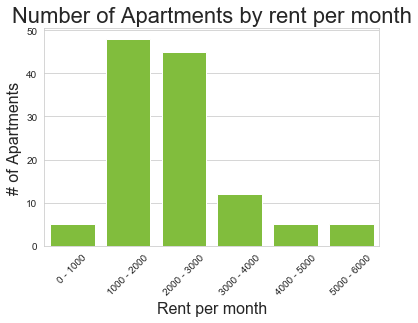

In [131]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

graph = sns.barplot(x=rent_ranges, y=n_in_range, color= (130/255, 210/255, 40/255))
graph.set_title('Number of Apartments by rent per month', size = 22)
graph.set_xlabel("Rent per month", size = 16)
graph.set_ylabel("# of Apartments", size = 16)
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)

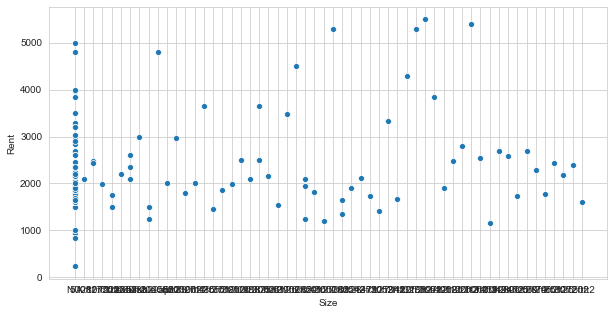

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compares Rent prices to apartment size
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_rental, x='Size', y='Rent', palette='Temperature', legend=False)